In [14]:
import os
from pathlib import Path
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets.folder import default_loader
from torchsummary import summary

In [2]:
device = torch.device('cuda')

batch_size = 64
epochs = 150


#Adam
lr = 0.0005
beta1 = 0.5
beta2 = 0.99
nz = 256

real_label = 1

Train_dir = Path('./AnimeDataset/faces/')

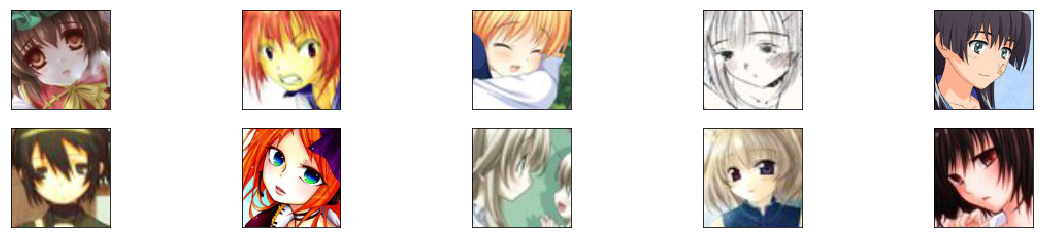

In [3]:
plt.figure(figsize=(20,4))
for i,frame in enumerate(Train_dir.iterdir()):
    if i == 10:
        break
    img = plt.imread(frame)
    plt.subplot(2,5,i+1),plt.imshow(img)
    plt.xticks([]),plt.yticks([])

In [4]:
class Generator(nn.Module):
    def __init__(self,nz,channels = 3):
        super(Generator,self).__init__()
        self.channels = channels
        self.nz = nz
        
        def conv_block(n_input, n_output, k_size, stride, padding):
            block=[
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block
        
        self.model = nn.Sequential(
            *conv_block(self.nz,1024,4,1,0),
            *conv_block(1024,512,4,2,1),
            *conv_block(512,256,4,2,1),
            *conv_block(256,128,4,2,1),
            *conv_block(128,64,4,2,1),
            nn.ConvTranspose2d(64,self.channels,3,1,1),
            nn.Tanh()
        )
        
    def forward(self,x):
        x = x.view(-1,self.nz,1,1)
        img = self.model(x)
        return img
            
gen = Generator(nz).to(device)
summary(gen,(nz,))        

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       4,194,304
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        def conv_block(n_input, n_output, k_size, stride, padding):
            block=[
                nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            return block
        
        self.model = nn.Sequential(
            *conv_block(3,32,4,2,1),
            *conv_block(32,64,4,2,1),
            *conv_block(64,128,4,2,1),
            *conv_block(128,256,4,2,1),
            nn.Conv2d(256,1,4,1,0),
        )
        
    def forward(self,img):
        x = self.model(img)
        return x
            
dis = Discriminator().to(device)
summary(dis,(3,64,64))        

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           1,536
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 16, 16]          32,768
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         LeakyReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7            [-1, 128, 8, 8]         131,072
       BatchNorm2d-8            [-1, 128, 8, 8]             256
         LeakyReLU-9            [-1, 128, 8, 8]               0
           Conv2d-10            [-1, 256, 4, 4]         524,288
      BatchNorm2d-11            [-1, 256, 4, 4]             512
        LeakyReLU-12            [-1, 256, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           4,097
Total params: 694,721
Trainable params:

In [6]:
class AnimiDataSet(Dataset):
    def __init__(self,train_path,transform_method=None,loader=default_loader):
        self.root = train_path
        self.transform = transform_method
        self.loader = default_loader
        self.imgs = self.getimg()
    
    def getimg(self):
        imgs = []
        for x in self.root.iterdir():
            img = self.loader(x)
            imgs.append(img)
        return imgs
    
    def __getitem__(self,index):
        if self.transform is not None:
            img = self.transform(self.imgs[index])
        return img
    
    def __len__(self):
        return len(self.imgs)

In [7]:
random_transform = [transforms.RandomRotation(degrees=10)]
transform = transforms.Compose([transforms.Resize((64,64)),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transform,p=0.2),
                                transforms.Resize((64,64)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = AnimiDataSet(Train_dir, transform_method=transform)
train_data_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

In [8]:
optimizer_g = optim.Adam(gen.parameters(),lr=lr, betas=(beta1, beta2))
optimizer_d = optim.Adam(dis.parameters(),lr=lr, betas=(beta1, beta2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


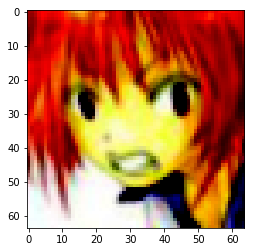

In [9]:
plt.imshow(train_data[1].numpy().transpose(1,2,0))

In [10]:
len(train_data_loader)

523

In [11]:
tcheck = time.time()

for epoch in range(epochs):
    for i, real_images in enumerate(train_data_loader):
        # --------------------------------------
        # Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))
        # --------------------------------------
        dis.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)
        
        output_real = dis(real_images)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = gen(noise)
        output_fake = dis(fake.detach())
        err_d = (torch.mean((output_real - torch.mean(output_fake) - labels) ** 2) + 
                 torch.mean((output_fake - torch.mean(output_real) + labels) ** 2)) / 2
        err_d.backward(retain_graph=True)
        optimizer_d.step()
        
        # --------------------------------------
        # Update Generator network: maximize log(D(G(z)))
        # --------------------------------------
        gen.zero_grad()

        output_fake = dis(fake)
        err_g = (torch.mean((output_real - torch.mean(output_fake) + labels) ** 2) +
                 torch.mean((output_fake - torch.mean(output_real) - labels) ** 2)) / 2
        err_g.backward()
        optimizer_g.step()
        
    print(f'[{epoch + 1}/{epochs}] Loss_d: {err_d.item():.4f} Loss_g: {err_g.item():.4f} time: {time.time()-tcheck:.2f}')
    tcheck=time.time()

[1/150] Loss_d: 0.5731 Loss_g: 7.1402 time: 77.24
[2/150] Loss_d: 1.9115 Loss_g: 6.8347 time: 78.07
[3/150] Loss_d: 1.6461 Loss_g: 15.0030 time: 78.22
[4/150] Loss_d: 1.2104 Loss_g: 14.7845 time: 78.58
[5/150] Loss_d: 1.1156 Loss_g: 15.4202 time: 78.49
[6/150] Loss_d: 0.4670 Loss_g: 3.5887 time: 77.52
[7/150] Loss_d: 1.0279 Loss_g: 16.2276 time: 77.10
[8/150] Loss_d: 0.3629 Loss_g: 8.6789 time: 77.23
[9/150] Loss_d: 0.2911 Loss_g: 1.1138 time: 79.23
[10/150] Loss_d: 0.5016 Loss_g: 12.7570 time: 122.90
[11/150] Loss_d: 0.1271 Loss_g: 3.4166 time: 145.06
[12/150] Loss_d: 1.2837 Loss_g: 0.3501 time: 144.87
[13/150] Loss_d: 0.3132 Loss_g: 11.7910 time: 145.39
[14/150] Loss_d: 1.2674 Loss_g: 0.4428 time: 145.04
[15/150] Loss_d: 0.1618 Loss_g: 8.1992 time: 145.13
[16/150] Loss_d: 2.4187 Loss_g: 9.9033 time: 145.02
[17/150] Loss_d: 0.7193 Loss_g: 0.2990 time: 145.09
[18/150] Loss_d: 0.2615 Loss_g: 5.7440 time: 145.40
[19/150] Loss_d: 0.2308 Loss_g: 1.6146 time: 145.53
[20/150] Loss_d: 0.3213 

In [15]:
def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

In [17]:
im_batch_size = 50

z = truncated_normal((im_batch_size, nz, 1, 1), threshold=1)
gen_z = torch.from_numpy(z).float().to(device)
gen_images = (gen(gen_z) + 1) / 2
images = gen_images.to('cpu').clone().detach()
images = images.numpy().transpose(0, 2, 3, 1)

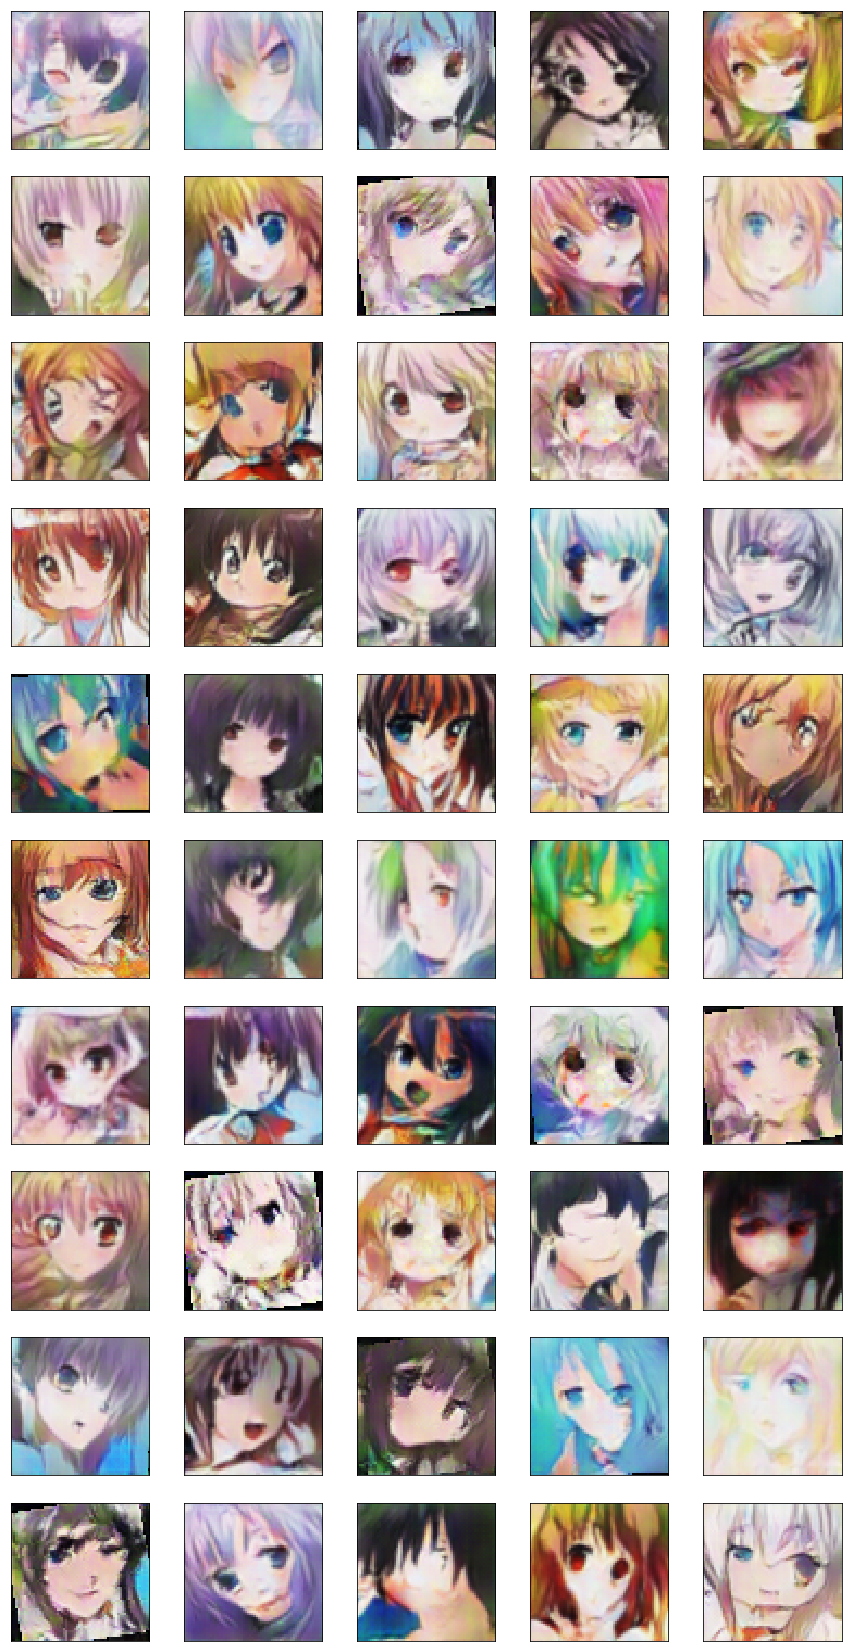

In [19]:
fig = plt.figure(figsize=(15, 30))
for i, j in enumerate(images):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])
    plt.imshow(j)

In [21]:
torch.save(gen, 'animi_gen_ralsgan.pkl')
torch.save(dis, 'animi_dis_ralsgan.pkl')

C:\Users\a2720\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\a2720\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Walk in Latent Space


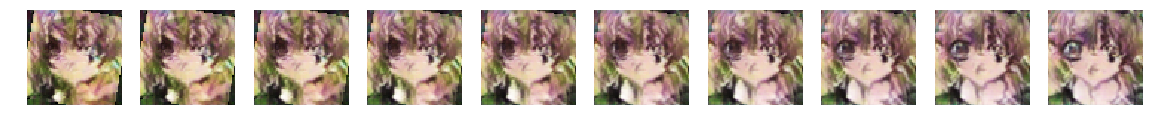

Walk in Latent Space


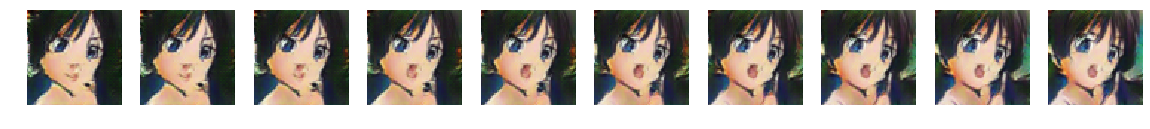

Walk in Latent Space


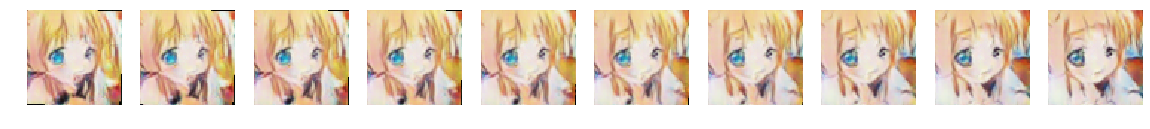

Walk in Latent Space


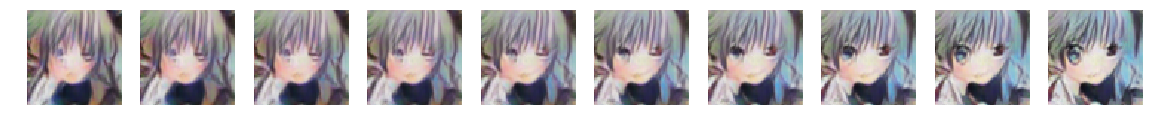

Walk in Latent Space


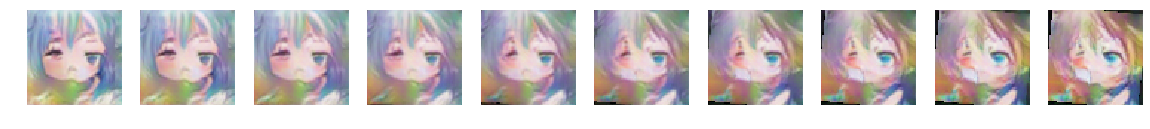

Walk in Latent Space


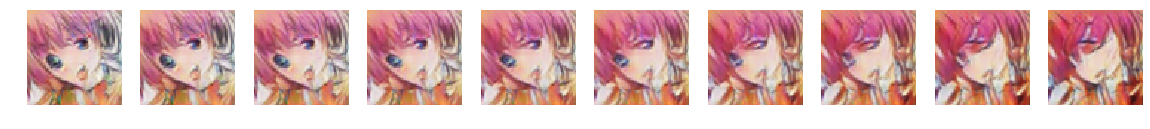

Walk in Latent Space


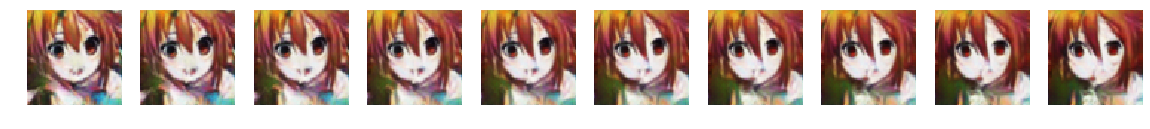

Walk in Latent Space


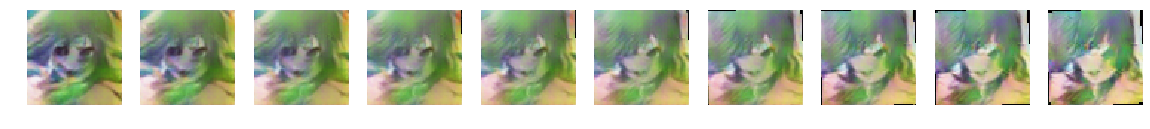

Walk in Latent Space


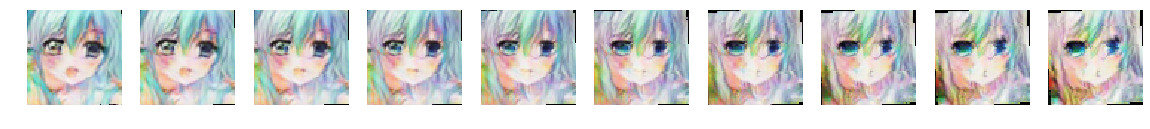

Walk in Latent Space


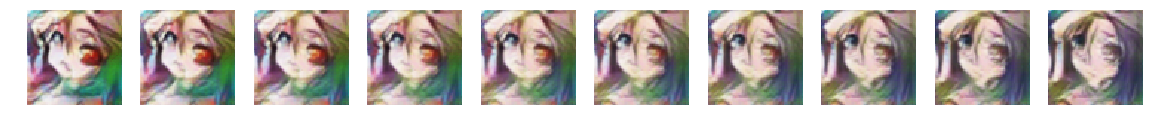

In [36]:
xx = truncated_normal((10, nz, 1, 1), threshold=1)
for k in range(10):
    print('Walk in Latent Space') 
    a = np.random.randint(int(nz/2)-20)
    b = np.random.randint(int(nz/2)-20)
    plt.figure(figsize=(20,2))
    for j in range(10):
        theta = j/9
        xx[k,a:a+20,0,0] = theta; xx[k,2*b:2*b+20,0,0] = 1-theta
        gen_z = torch.from_numpy(xx).float().to(device)
        plt.subplot(1,10,j+1)
        img = (gen(gen_z) + 1) / 2
        images = img.to('cpu').clone().detach()
        images = images.numpy().transpose(0, 2, 3, 1)
        plt.axis('off')
        plt.imshow(images[k])
    plt.show()